# 더미데이터 생성 및 저장

In [ ]:
# 더미 데이터 생성
import pandas as pd
import numpy as np

np.random.seed(42)

n = 80
df = pd.DataFrame({
    "student_id": np.arange(1, n+1),
    "study_time": np.round(np.random.gamma(shape=2.0, scale=2.0, size=n), 1),          # 주간 학습시간(대충 0~15)
    "assignment_rate": np.round(np.clip(np.random.normal(0.75, 0.18, n), 0, 1), 2),    # 과제 제출률(0~1)
    "lms_login": np.random.randint(0, 30, n),                                          # 접속 횟수
    "absence": np.random.poisson(0.6, n),                                              # 결석
    "late": np.random.poisson(0.8, n),                                                 # 지각
})

# 성적(타겟) 생성: 학습시간/과제/접속은 +, 결석/지각은 -
noise = np.random.normal(0, 6, n)
df["total_score"] = np.round(
    55
    + df["study_time"] * 2.2
    + df["assignment_rate"] * 25
    + df["lms_login"] * 0.4
    - df["absence"] * 6
    - df["late"] * 3
    + noise
, 1)

df.head()

,student_id,study_time,assignment_rate,lms_login,absence,late,total_score
0,1,4.8,0.58,11,1,0,75.4
1,2,3.0,1.00,18,1,1,91.1
2,3,2.8,0.61,22,1,3,68.8
3,4,2.8,0.69,14,1,0,77.5
4,5,9.3,0.90,27,0,0,118.9


In [ ]:
# CSV로 저장
import os
os.makedirs("../data/raw", exist_ok=True)
df.to_csv("../data/raw/student_learning.csv", index=False, encoding="utf-8-sig")

# 이미지 저장 함수 준비

## 저장 폴더 생성

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# 저장 폴더
FIG_DIR = Path("../reports/figures")
TAB_DIR = Path("../reports/tables")
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("Figure directory:", FIG_DIR.resolve())
print("Table directory:", TAB_DIR.resolve())

Figure directory: D:\workSpace\edutech-learning-analysis\reports\figures
Table directory: D:\workSpace\edutech-learning-analysis\reports\tables


## 저장 함수

In [2]:
# 그래프 저장 함수
def savefig(name: str):
    """현재 matplotlib figure를 파일로 저장"""
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"saved: {path}")

# 학습 유형 탐색적 분석

## 데이터셋

In [3]:
import sys
sys.path.append("..")

from src.preprocessing import load_csv, preprocess_pipeline

df = load_csv("../data/raw/student_learning.csv")
df = preprocess_pipeline(df, clip_outliers=True)
df.head()

,student_id,study_time,assignment_rate,lms_login,absence,late,total_score
0,1,4.800,0.58,11,1.0,0.0,75.4
1,2,3.000,1.00,18,1.0,1.0,91.1
2,3,2.800,0.61,22,1.0,2.5,68.8
3,4,2.800,0.69,14,1.0,0.0,77.5
4,5,8.025,0.90,27,0.0,0.0,114.4


## 데이터 요약

In [4]:

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       80 non-null     int64  
 1   study_time       80 non-null     float64
 2   assignment_rate  80 non-null     float64
 3   lms_login        80 non-null     int64  
 4   absence          80 non-null     float64
 5   late             80 non-null     float64
 6   total_score      80 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 4.5 KB


student_id         0
study_time         0
assignment_rate    0
lms_login          0
absence            0
late               0
total_score        0
dtype: int64

## 분포 확인

saved: ..\reports\figures\hist_total_score.png


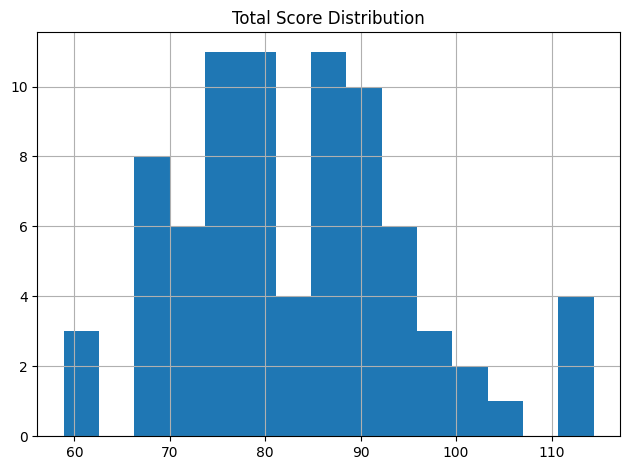

In [5]:
import matplotlib.pyplot as plt

df["total_score"].hist(bins=15)
plt.title("Total Score Distribution")
savefig("hist_total_score.png")
plt.show()

## 상관관계 히트맵

saved: ..\reports\figures\correlation_heatmap.png


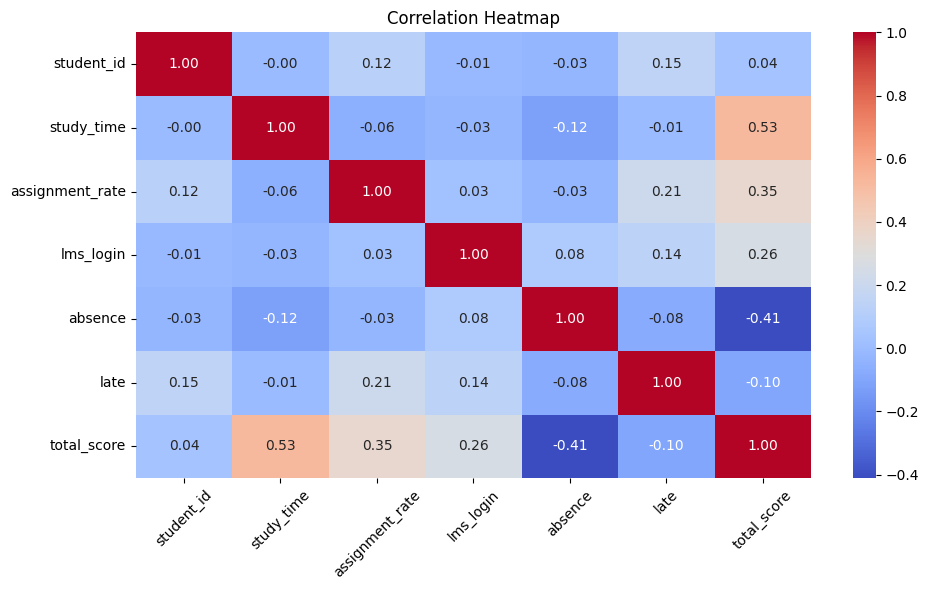

In [6]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
savefig("correlation_heatmap.png")
plt.show()

## 핵심 산점도 시각화

saved: ..\reports\figures\scatter_study_time_vs_score.png


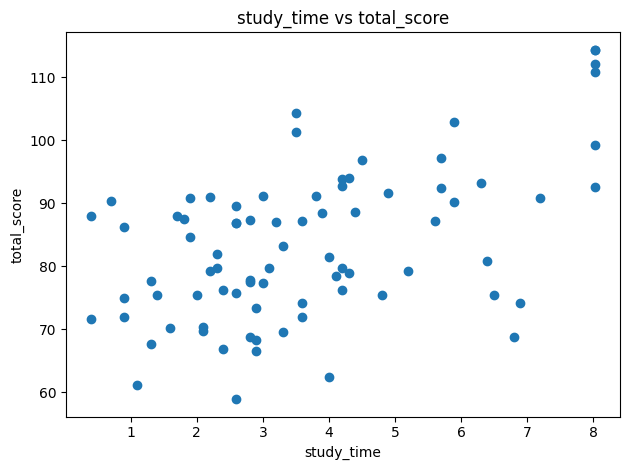

saved: ..\reports\figures\scatter_assignment_vs_score.png


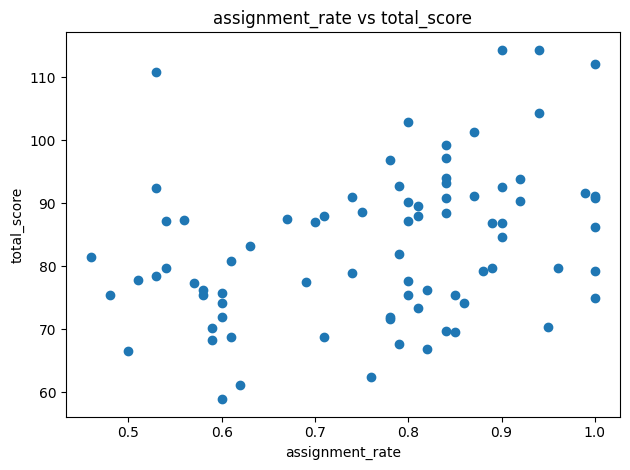

In [7]:
plt.scatter(df["study_time"], df["total_score"])
plt.xlabel("study_time")
plt.ylabel("total_score")
plt.title("study_time vs total_score")
savefig("scatter_study_time_vs_score.png")
plt.show()

plt.scatter(df["assignment_rate"], df["total_score"])
plt.xlabel("assignment_rate")
plt.ylabel("total_score")
plt.title("assignment_rate vs total_score")
savefig("scatter_assignment_vs_score.png")
plt.show()

## 상/하위 그룹 비교(20%)

In [10]:

top = df.nlargest(int(len(df)*0.2), "total_score")
bottom = df.nsmallest(int(len(df)*0.2), "total_score")

print(top.mean(numeric_only=True), '\n')
print(bottom.mean(numeric_only=True))

student_id          48.625000
study_time           5.996875
assignment_rate      0.828750
lms_login           19.187500
absence              0.375000
late                 0.812500
total_score        100.800000
dtype: float64 

student_id         43.937500
study_time          2.550000
assignment_rate     0.711875
lms_login          13.437500
absence             1.343750
late                1.000000
total_score        67.787500
dtype: float64


## EduTech 학습 데이터 탐색적 분석 (EDA) 결과 보고서

본 보고서는 EduTech 플랫폼에서 수집된 학생 학습 데이터를 바탕으로 수행한 탐색적 데이터 분석(EDA)의 주요 결과를 요약한 것이다.

### 성적과 상관관계가 높은 변수

분석 결과, 총점(total_score)과 높은 상관을 보인 변수는 다음과 같다.

1. 과제 제출률 (assignment_rate)
2. 학습시간 (study_time)
3. LMS 접속 횟수 (lms_login)

특히 과제 제출률은 성적과 가장 높은 양의 상관관계를 보였으며,<br>
지속적인 과제 수행이 학업 성취에 중요한 영향을 미치는 것으로 해석된다.

### 상위권·하위권 학습행동 차이

상위 20%와 하위 20% 학생의 평균을 비교한 결과 다음과 같은 차이가 확인되었다.

1. 상위권은 주간 학습시간이 약 2배 높음
2. 과제 제출률이 30% 이상 높음
3. 결석 및 지각 횟수가 현저히 낮음

이는 학습시간뿐 아니라 학습 지속성(과제 수행, 출결)이 성취도에 복합적으로 작용함을 시사한다.

### 교육 현장 적용 방안

1. 과제 제출률 기반 위험군 탐지<br>
   과제 제출률이 50% 이하인 학생을 자동 탐지하여<br>
   최성보 예방 프로그램 선정 학생의 기준을 마련할 수 있다.

2. LMS 접속 패턴 기반 학습 개입<br>
   LMS 접속 횟수가 낮은 학생에게는<br>
   학습 알림 및 보충 자료 제공 시스템을 구축할 수 있다.

# K-means 클러스터링 결과 분석

## 클러스터링 입력 변수 준비

In [12]:
features = ["study_time", "assignment_rate", "lms_login", "absence", "late"]

X = df[features].copy()

X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)
print("Number of NaN values in X_scaled:", np.isnan(X_scaled).sum())

X_scaled shape: (80, 5)
Number of NaN values in X_scaled: 0


## KMeans 학습

In [13]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts().sort_index()

cluster
0    38
1    31
2    11
Name: count, dtype: int64

## 검증: 클러스터별 특징 테이블 생성

In [14]:
cluster_profile = df.groupby("cluster")[features].mean().round(3)
cluster_profile

cluster_profile.to_csv(TAB_DIR / "cluster_profile_mean.csv", encoding="utf-8-sig")
print("saved:", TAB_DIR / "cluster_profile_mean.csv")

cluster_score = df.groupby("cluster")["total_score"].agg(["count", "mean", "median"]).round(2)
cluster_score

cluster_score.to_csv(TAB_DIR / "cluster_score_summary.csv", encoding="utf-8-sig")
print("saved:", TAB_DIR / "cluster_score_summary.csv")


saved: ..\reports\tables\cluster_profile_mean.csv
saved: ..\reports\tables\cluster_score_summary.csv


## 시각화 1: 2D 산점도 저장

saved: ..\reports\figures\kmeans_scatter_studytime_assignment.png


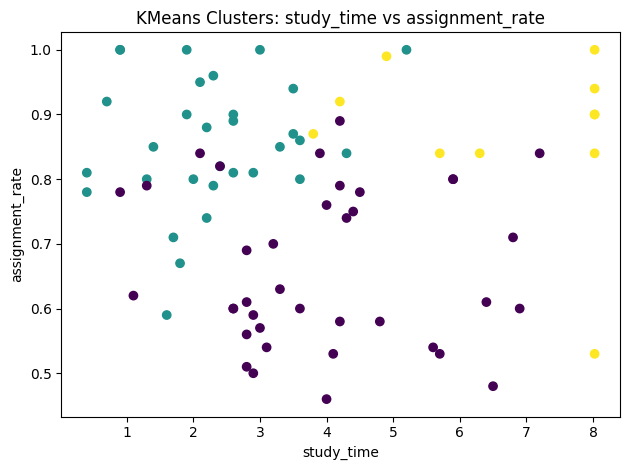

In [15]:
plt.figure()
plt.scatter(df["study_time"], df["assignment_rate"], c=df["cluster"])
plt.xlabel("study_time")
plt.ylabel("assignment_rate")
plt.title("KMeans Clusters: study_time vs assignment_rate")
savefig("kmeans_scatter_studytime_assignment.png")
plt.show()

## 시각화 2: 클러스터별 성적 분포(박스플롯)

saved: ..\reports\figures\kmeans_boxplot_total_score_by_cluster.png


<Figure size 640x480 with 0 Axes>

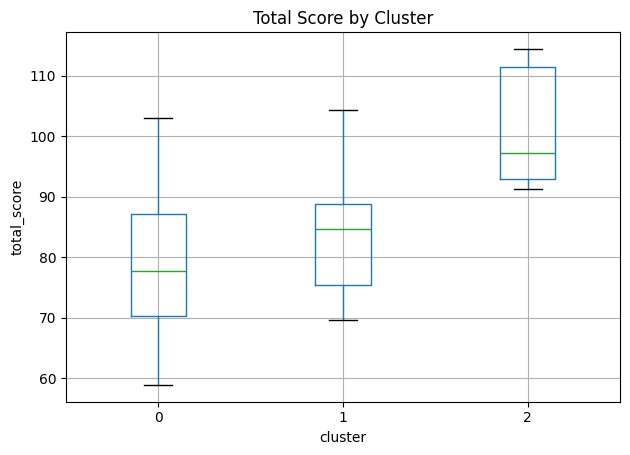

In [16]:
plt.figure()
df.boxplot(column="total_score", by="cluster")
plt.title("Total Score by Cluster")
plt.suptitle("")  # 상단 자동 제목 제거
plt.xlabel("cluster")
plt.ylabel("total_score")
savefig("kmeans_boxplot_total_score_by_cluster.png")
plt.show()

In [21]:
print(df["cluster"].value_counts())

df.groupby("cluster")[features].mean()

cluster
0    38
1    31
2    11
Name: count, dtype: int64


,study_time,assignment_rate,lms_login,absence,late
cluster,,,,,
0,3.939474,0.662105,15.631579,1.039474,0.605263
1,2.293548,0.856129,15.387097,0.322581,0.919355
2,6.640909,0.870000,21.818182,0.181818,0.909091


## 클러스터링 결과 요약

K-Means(n=3) 기반 학습행동 클러스터링 결과,
전체 학생은 다음과 같이 분류되었다.

- Cluster 0: 38명 (47.5%)
- Cluster 1: 31명 (38.8%)
- Cluster 2: 11명 (13.7%)

Cluster 0과 1은 전체의 약 86%를 차지하는 일반 학습군으로 해석되며,
Cluster 2는 소수 집단으로 학습 참여도 및 성취도 측면에서
집중 관리가 필요한 위험군일 가능성이 높다.

### 교육 현장 적용 시사점

- Cluster 2에 속한 학생은 결석, 과제 제출률, LMS 참여도 등의
  학습행동 지표를 기준으로 조기 탐지하여 상담 및 보충학습 개입이 필요하다.

- Cluster 1은 참여도는 있으나 성취도 변동성이 존재할 수 있으므로
  학습 피드백 강화 및 과제 수행 관리가 요구된다.

- Cluster 0은 전반적으로 안정적인 학습행동을 보이므로
  지속적인 동기부여와 심화학습 기회를 제공하는 것이 바람직하다.